In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to ROOTaaS 6.06/04


/bigdata/shared/Software/root/Current/lib/ROOT.py:303: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )


setGPU: Setting GPU to: 5


In [2]:
def convert(tree, target=0):
    feature = tree2array(tree,
                        branches = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
                                   ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
                                   'leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt','Higgs_eta' ],
                        selection = 'dRmm>-9000.')
    if target == 0:
        label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
    else:
        label = np.ones(shape = feature.shape, dtype=[('label','f4')])
    #data = nlr.merge_arrays([label,feature], flatten=True)
    #auxInfo = tree2array(tree,
    #                     branches = ['mass_jj','mass_gg'])
    return feature

In [3]:
SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'

sigfile = rt.TFile.Open(SIGNAL_FILE)
bkgfile = rt.TFile.Open(BKG_FILE)
sigtree = sigfile.Get("cattree")
bkgtree = bkgfile.Get("cattree")
signp = convert(sigtree, 1)
bkgnp = convert(bkgtree, 0)

sig_frame = pd.DataFrame.from_records(signp)
#sig_aux_frame = pd.DataFrame.from_records(sig_auxnp)
bkg_frame = pd.DataFrame.from_records(bkgnp)
#bkg_aux_frame = pd.DataFrame.from_records(bkg_auxnp)

#print sig_frame, bkg_frame

# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix]
signal_ = signal_[:len(background)]

background_ = background[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [4]:
bkg_frame.head()

,dRmm,dEtamm,dPhimm,M_jj,dEta_jj,Zep,dRmin_mj,dRmax_mj,dRmin_mmj,dRmax_mmj,dPhijj,leadingJet_pt,subleadingJet_pt,leadingJet_eta,subleadingJet_eta,cthetaCS,Higgs_mass,Higgs_pt,Higgs_eta
0,-0.394970,-0.523290,0.884562,-0.504544,0.913912,-0.056047,-0.391921,-0.627932,-1.357354,-0.452749,-1.246910,0.200462,-0.708425,0.564546,-1.030905,-0.420533,-0.716298,0.646942,-0.756356
1,-1.028938,-0.159086,-0.695440,-0.502013,0.979207,-0.008141,0.642067,0.032515,0.770401,0.101550,0.005806,-0.172857,-0.669904,0.106789,-1.507105,-0.209246,-0.378669,0.479559,-0.229568
2,0.441302,0.725683,-1.153352,-0.510417,1.150898,0.079046,-0.071969,0.783194,0.539766,1.110574,-0.348370,-0.836470,-0.606784,0.688083,-1.316701,0.707963,-0.652392,-0.622234,1.094608
3,-0.680852,0.287553,-0.807200,3.112848,-1.409949,-0.077053,0.228980,1.423399,0.763542,0.794313,-0.976699,0.172199,-0.383546,-1.001142,1.485232,0.320826,-0.566608,0.272475,-0.866568
4,1.409754,-2.102611,1.165913,-0.313263,-1.000311,-0.049022,-0.580312,0.501938,-0.864826,-0.437022,-1.323360,-0.550298,-0.301862,-1.870930,0.115708,-1.593333,-0.519003,-0.906637,-0.784061


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

Using TensorFlow backend.
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.8.0 locally


In [6]:
for train_index, test_index in skf.split(data, label):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

In [7]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=19,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(23738, 19)
(23738,)
(5934, 19)
(5934,)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 100)           2000        dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             101         dropout_1[0][0]                  
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
____________________________________________________________________________________________________


In [ ]:
plt.plot(bkg_frame['Zep'])

In [9]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [10]:
hist = model.fit(x_train, y_train, batch_size=150, nb_epoch=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Train on 18990 samples, validate on 4748 samples
Epoch 1/50
18990/18990 [==============================] - 1s - loss: 0.4799 - acc: 0.7889 - val_loss: 0.5885 - val_acc: 0.7426
Epoch 2/50
18990/18990 [==============================] - 0s - loss: 0.3690 - acc: 0.8691 - val_loss: 0.5564 - val_acc: 0.7612
Epoch 3/50
18990/18990 [==============================] - 0s - loss: 0.3344 - acc: 0.8796 - val_loss: 0.5214 - val_acc: 0.7645
Epoch 4/50
18990/18990 [==============================] - 0s - loss: 0.3065 - acc: 0.8856 - val_loss: 0.4479 - val_acc: 0.7848
Epoch 5/50
18990/18990 [==============================] - 0s - loss: 0.2845 - acc: 0.8915 - val_loss: 0.4147 - val_acc: 0.7951
Epoch 6/50
18990/18990 [==============================] - 0s - loss: 0.2666 - acc: 0.8990 - val_loss: 0.3972 - val_acc: 0.8035
Epoch 7/50
18990/18990 [==============================] - 0s - loss: 0.2526 - acc: 0.9034 - val_loss: 0.3754 - val_acc: 0.8130
Epoch 8/50
18990/18990 [==============================] - 0s -

W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE3 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/

In [11]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

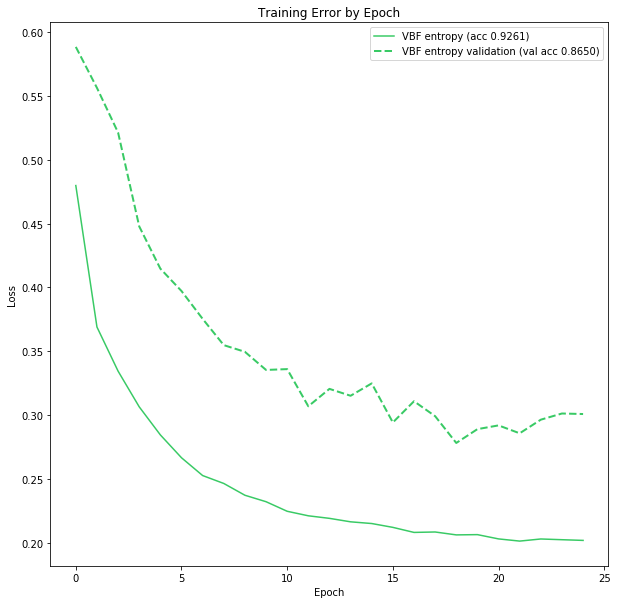

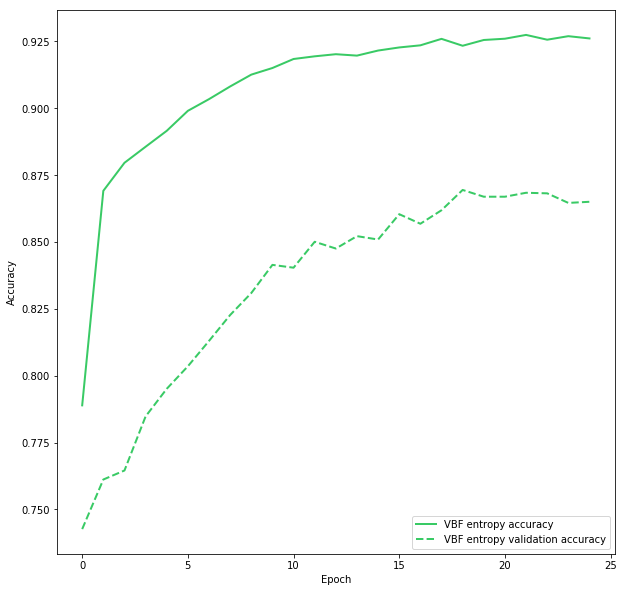

In [12]:
show_losses( [("VBF entropy", hist)])

In [13]:
def accuracy( p ):
    p_cat = np.argmax(p,axis=1)
    print "Fraction of good prediction"
    print len(np.where( p_cat == y_test)[0])
    print len(np.where( p_cat == y_test )[0])/float(len(p_cat)),"%"

In [14]:
accuracy( model.predict(x_test) )

Fraction of good prediction
2967
0.5 %


In [15]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [16]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

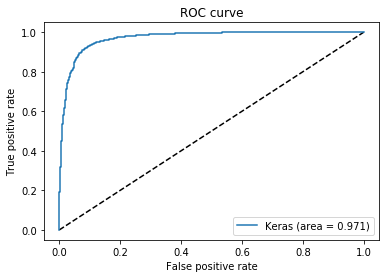

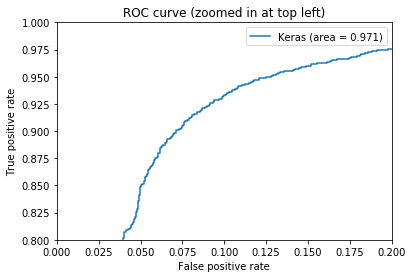

In [17]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

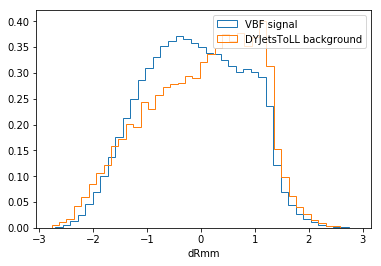

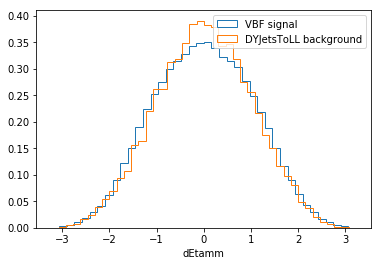

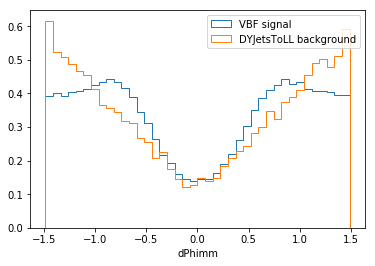

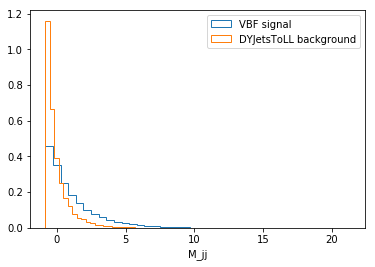

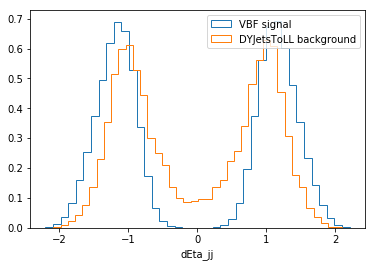

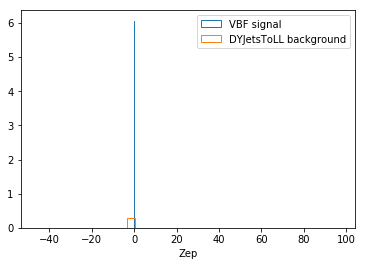

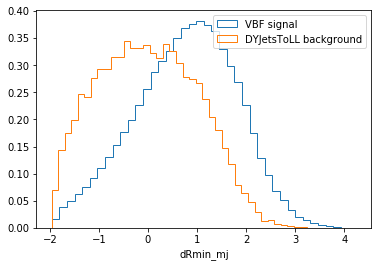

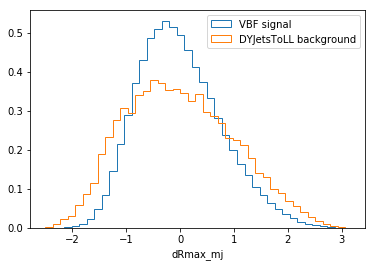

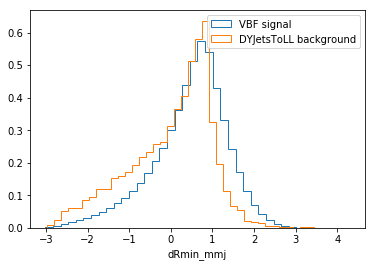

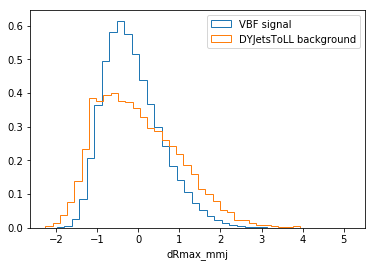

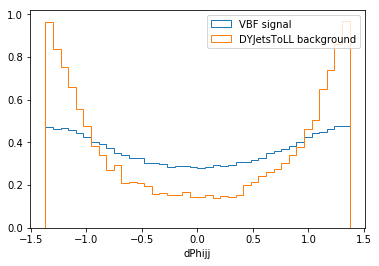

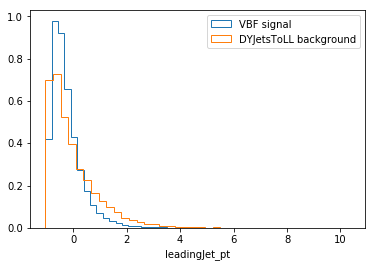

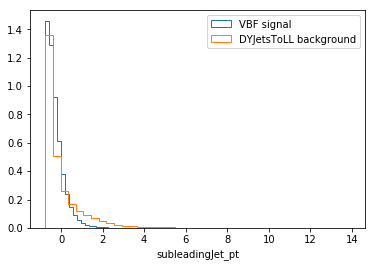

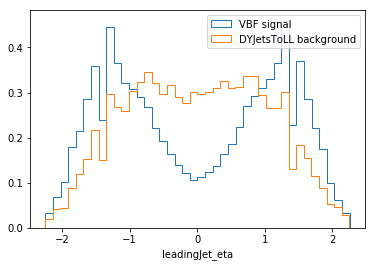

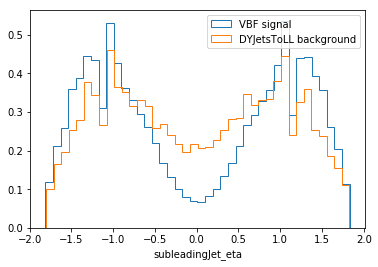

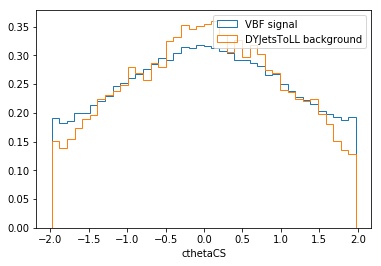

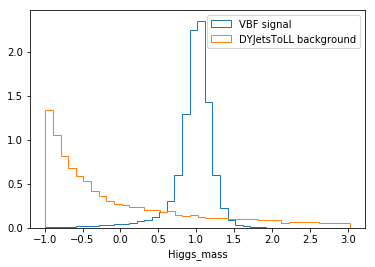

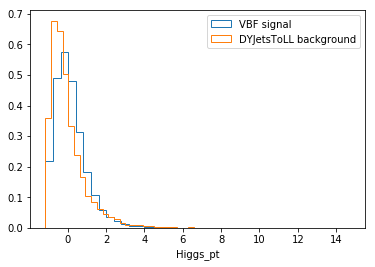

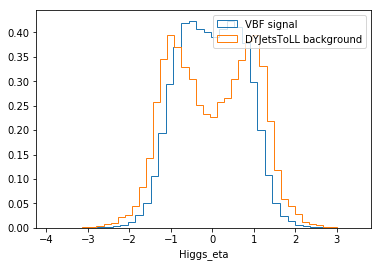

In [18]:
HLFs = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj','dRmin_mmj','dRmax_mmj','dPhijj',
        'leadingJet_pt','subleadingJet_pt','leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt',
        'Higgs_eta']

for hlf in HLFs:
    plt.figure()
    plt.hist(sig_frame[hlf], bins=40, normed=True, histtype='step', label='VBF signal')
    plt.hist(bkg_frame[hlf], bins=40, normed=True, histtype='step', label='DYJetsToLL background')
    plt.xlabel(hlf)
    plt.legend(loc='best')